In [235]:
# Import data using a pkl file
import pickle as p

import pymongo
import pandas as pd
from matplotlib import pyplot as plt

# Used to sort dictionary
import operator

# To get data-structure OrderedDict() 
import collections

# Required to pre-process/encode data that can be fed to linear/SVM models
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

# Using DecisionTrees to classify/predict outcomes
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Visualize a Decision-Tree (TO-DO)
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus


In [20]:
pkl_file = open('mypkl.pkl', 'rb')
dfw_dict = p.load(pkl_file)

# Examine a few key/values, get size of data
flow_count = 0
active_sources = []
for ip in dfw_dict:
    if dfw_dict[ip]:
        flow_count += len(dfw_dict[ip])
        active_sources.append(ip)
print('Active sources: %d, Active flows: %d' %(len(active_sources), 
                                               flow_count))

Active sources: 80, Active flows: 77423


In [134]:
# Instantiate an instance of Mongo-db and copy the data over
# Sample flow:
# 2020-12-05T20:51:02.220Z 073596a1 INET match DROP 2026 IN 36 PROTO 2 0.0.0.0->224.0.0.1
# 2020-12-05T20:51:02.428Z 073596a1 INET match DROP 2026 OUT 92 UDP 192.2.0.2/45325->20.20.0.1/53
# 2020-12-05T20:18:52.003Z b5de0e44 INET TERM 3106 IN TCP FIN 100.64.48.39/4302->192.2.0.118/80 5/5 401/593
# 2020-12-05T09:11:30.739Z 073596a1 INET match DROP 2026 OUT 60 TCP 192.2.0.2/46164->192.2.0.4/9887 S
# 2020-12-05T20:19:39.367Z cf6e2066 INET match PASS 1075 IN 88 ICMP 192.1.0.209->192.1.0.213
# Example format of records/documents:
# +------------------------------------------------------------------------------------------------+
# |Time | Host | Reason | Action | Rule | Dir | Len | Proto |Src-IP      |S-port| Dst-IP    |D-port| 
# +------------------------------------------------------------------------------------------------+
# |<>   | <>   | match  | DROP   | 2026 | IN  | 36  | 2     |0.0.0.0     |      |224.0.0.1  |      |
# |<>   | <>   | match  | DROP   | 2026 | OUT | 92  | UDP   |192.2.0.2   |45325 |20.20.0.1  | 53   |
# |<>   | <>   | 0      | TERM   | 3106 | IN  | 0   | TCP   |100.64.48.39|4302  |192.2.0.118| 9887 |
# |<>   | <>   | match  | DROP   | 2026 | OUT | 60  | TCP   |192.2.0.2   |46164 |192.2.0.4  | 9887 |
# |<>   | <>   | match  | PASS   | 1075 | IN  | 88  | ICMP  |192.1.0.209 |      |192.1.0.213|      |
# +------------------------------------------------------------------------------------------------+
# * NOTE - Since s-port can be ephimeral, we can skip adding it.
#

def get_ip_port(_str):
    '''
    Simple utility to extract ip/port from the flow
    '''
    _items = _str.split('->')
    ip = []
    port = []
    for _item in _items:
        if '/' in _item:
            ip.append(_item.split('/')[0])
            port.append(_item.split('/')[1])
        else:
            ip.append(_item)
            port.append(0)
    return(ip[0], ip[1], port[0], port[1])
            
        
# Connect to the Mongo-DB server
client = pymongo.MongoClient('localhost', 27017)

# Create a new DB and collection

db = client.flowdb

# Drop a collection if it exists
for collection in db.list_collection_names():
    if collection == 'flowtable':
        print('Found collection {0}. Removing it!'.format(collection))
        db.flowtable.drop()

flow_collection = db.flowtable

# Walk all flows and create a document for each
for src in active_sources:
    for flow in dfw_dict[src]:
        flow_attrib = flow.split()
        _time = flow_attrib[0]
        _src = src
        _reason = flow_attrib[3]
        _action = flow_attrib[4]
        _ruleid = flow_attrib[5]
        _dir = flow_attrib[6]
        
        if 'PROTO' in flow_attrib:
            _pktlen = flow_attrib[7] 
            _proto = flow_attrib[9]
            _sip, _dip, _sport, _dport = get_ip_port(flow_attrib[10]) 
        elif 'match' in flow_attrib:
            _pktlen = flow_attrib[7] 
            _proto = flow_attrib[8]
            _sip, _dip, _sport, _dport = get_ip_port(flow_attrib[9]) 
        elif 'TCP' in flow_attrib:
            _pktlen = 0
            _reason = 0
            _action = flow_attrib[3]
            _ruleid = flow_attrib[4]
            _proto = flow_attrib[6]
            _sip, _dip, _sport, _dport = get_ip_port(flow_attrib[8]) 
        elif 'UDP' in flow_attrib:
            _pktlen = 0
            _reason = 0
            _action = flow_attrib[3]
            _ruleid = flow_attrib[4]
            _proto = flow_attrib[6]
            _sip, _dip, _sport, _dport = get_ip_port(flow_attrib[7]) 
        doc = {'time': _time, 'source': _src, 'reason': _reason, 'action': _action, 
               'rule': _ruleid, 'dir': _dir, 'pktlen': _pktlen,
               'proto': _proto, 'sip': _sip, 'dip': _dip, 
               'sport': _sport, 'dport': _dport}
        # Insert into collection
        flow_collection.insert(doc) 
        
print('Completed adding flow records to database!')

Found collection flowtable. Removing it!


<ipython-input-134-e3a9a05bb2d6>:91: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  flow_collection.insert(doc)


Completed adding flow records to database!


In [135]:
# Fetch + examine a few entries from Mongo-DB
doclist = flow_collection.find()
for doc in doclist[:10]:
    print(doc)
print('Total records in the DB = {0}'.format(doclist.count()))
    


{'_id': ObjectId('5fcca3b6a7d4d6819b6e9ead'), 'time': '2020-12-05T20:51:02.220Z', 'source': '20.20.177.78', 'reason': 'match', 'action': 'DROP', 'rule': '2026', 'dir': 'IN', 'pktlen': '36', 'proto': '2', 'sip': '0.0.0.0', 'dip': '224.0.0.1', 'sport': 0, 'dport': 0}
{'_id': ObjectId('5fcca3b7a7d4d6819b6e9eae'), 'time': '2020-12-05T20:51:02.220Z', 'source': '20.20.177.78', 'reason': 'match', 'action': 'DROP', 'rule': '2026', 'dir': 'IN', 'pktlen': '36', 'proto': '2', 'sip': '0.0.0.0', 'dip': '224.0.0.1', 'sport': 0, 'dport': 0}
{'_id': ObjectId('5fcca3b7a7d4d6819b6e9eaf'), 'time': '2020-12-05T20:51:02.220Z', 'source': '20.20.177.78', 'reason': 'match', 'action': 'DROP', 'rule': '2026', 'dir': 'IN', 'pktlen': '76', 'proto': 'ICMP', 'sip': 'fe80::ffff:ffff:ffff:ffff', 'dip': 'ff02::1', 'sport': 0, 'dport': 0}
{'_id': ObjectId('5fcca3b7a7d4d6819b6e9eb0'), 'time': '2020-12-05T20:51:02.220Z', 'source': '20.20.177.78', 'reason': 'match', 'action': 'DROP', 'rule': '2026', 'dir': 'IN', 'pktlen':

<ipython-input-135-b830423d2e77>:5: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  print('Total records in the DB = {0}'.format(doclist.count()))


In [200]:
def create_flows_df(doclist):
    time = []
    src = []
    reason = []
    action = []
    rule = []
    _dir = []
    pktlen = []
    proto = []
    sip = []
    dip = []
    sport = []
    dport = []
    
    for doc in doclist:
        time.append(doc['time'])
        src.append(doc['source'])
        reason.append(doc['reason'])
        action.append(doc['action'])
        rule.append(doc['rule'])
        _dir.append(doc['dir'])
        pktlen.append(doc['pktlen'])
        proto.append(doc['proto'])
        sip.append(doc['sip'])
        dip.append(doc['dip'])
        sport.append(doc['sport'])
        dport.append(doc['dport'])
    # Create a dict
    flow_dict = {'time': time,
                 'reason': reason,
                 'source': src,
                 'action': action,
                 'rule': rule,
                 'dir': _dir,
                 'pktlen': pktlen,
                 'proto': proto,
                 'sip': sip,
                 'dip': dip,
                 'sport': sport,
                 'dport': dport}
    _df = pd.DataFrame(flow_dict)
    return _df


# Load data into a Pandas DataFrame
doclist = flow_collection.find()
df = create_flows_df(doclist)
df

,time,reason,source,action,rule,dir,pktlen,proto,sip,dip,sport,dport
0,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,36,2,0.0.0.0,224.0.0.1,0,0
1,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,36,2,0.0.0.0,224.0.0.1,0,0
2,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,76,ICMP,fe80::ffff:ffff:ffff:ffff,ff02::1,0,0
3,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,36,2,0.0.0.0,224.0.0.1,0,0
4,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,76,ICMP,fe80::ffff:ffff:ffff:ffff,ff02::1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
77418,2020-12-05T21:01:26.152Z,0,20.20.177.139,TERM,1018,TCP,0,TCP,192.1.0.4,192.1.0.3,38802,9887
77419,2020-12-05T21:02:16.306Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,59158,53
77420,2020-12-05T21:02:16.306Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,51603,53
77421,2020-12-05T21:02:17.320Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,38484,53


In [201]:
# After examining the data, found proto to have values '2' which 
# we will transform to 'IGMP' to keep data-types uniform
df['proto'] = df['proto'].replace({'2':'IGMP'})
df

,time,reason,source,action,rule,dir,pktlen,proto,sip,dip,sport,dport
0,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,36,IGMP,0.0.0.0,224.0.0.1,0,0
1,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,36,IGMP,0.0.0.0,224.0.0.1,0,0
2,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,76,ICMP,fe80::ffff:ffff:ffff:ffff,ff02::1,0,0
3,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,36,IGMP,0.0.0.0,224.0.0.1,0,0
4,2020-12-05T20:51:02.220Z,match,20.20.177.78,DROP,2026,IN,76,ICMP,fe80::ffff:ffff:ffff:ffff,ff02::1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
77418,2020-12-05T21:01:26.152Z,0,20.20.177.139,TERM,1018,TCP,0,TCP,192.1.0.4,192.1.0.3,38802,9887
77419,2020-12-05T21:02:16.306Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,59158,53
77420,2020-12-05T21:02:16.306Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,51603,53
77421,2020-12-05T21:02:17.320Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,38484,53


In [239]:
# Convert sport/dport columns to integers 
df.sport = df.sport.astype(int)
df.dport = df.dport.astype(int)

print('AS-types of dataframe:')
df.info()
df.tail()

AS-types of dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77423 entries, 0 to 77422
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    77423 non-null  object
 1   reason  77423 non-null  object
 2   source  77423 non-null  object
 3   action  77423 non-null  object
 4   rule    77423 non-null  object
 5   dir     77423 non-null  object
 6   pktlen  77423 non-null  object
 7   proto   77423 non-null  object
 8   sip     77423 non-null  object
 9   dip     77423 non-null  object
 10  sport   77423 non-null  int64 
 11  dport   77423 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 7.1+ MB


,time,reason,source,action,rule,dir,pktlen,proto,sip,dip,sport,dport
77418,2020-12-05T21:01:26.152Z,0,20.20.177.139,TERM,1018,TCP,0,TCP,192.1.0.4,192.1.0.3,38802,9887
77419,2020-12-05T21:02:16.306Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,59158,53
77420,2020-12-05T21:02:16.306Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,51603,53
77421,2020-12-05T21:02:17.320Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,38484,53
77422,2020-12-05T21:02:17.320Z,match,20.20.177.139,PASS,1018,OUT,81,UDP,192.1.0.3,20.20.0.1,40096,53


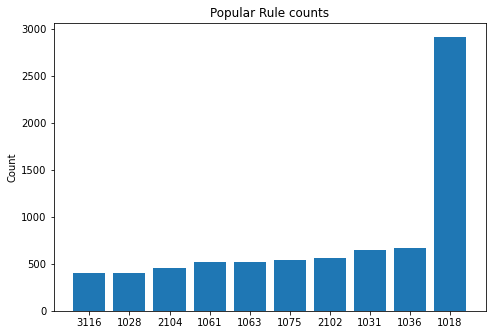

In [222]:
def plot_graph(_df, _attr, title=None, type='bar'):
    '''
    Plot a bar-chart of the top-10 counts of the attribute
    '''
    my_dict = {}
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    for i in _df[_attr]:
        try:
            my_dict[i] += 1
        except KeyError:
            my_dict[i] = 0
    sorted_items = sorted(my_dict.items(), key=operator.itemgetter(1))
    if len(sorted_items) > 10:
        sorted_dict = collections.OrderedDict(sorted_items[len(sorted_items)-10-1:len(sorted_items)-1])
    else:
        sorted_dict = collections.OrderedDict(sorted_items)
    # Plot based on type
    if type == 'bar':
        ax.bar(sorted_dict.keys(), sorted_dict.values())
        ax.set_ylabel('Count')
        ax.set_title(title)
    elif type == 'pie':
        ax.pie(sorted_dict.values(), labels=sorted_dict.keys(), 
               autopct='%1.1f%%', shadow=True, radius=1.2,
               startangle=90)
        ax.axis('equal')
        # plt.legend(sorted_dict.values(), labels=sorted_dict.keys(), loc='left center', 
        #           bbox_to_anchor=(-0.1, 1.),
        #           fontsize=8)
    plt.show()

# Plot graph based on rule-count 
plot_graph(df, 'rule', title='Popular Rule counts')

# Outcome-1: The most popular Rule is Rule-ID 1018

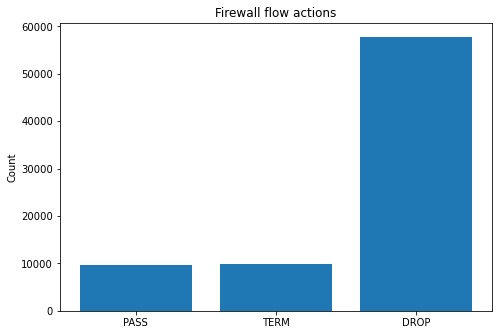

In [223]:
# Plot graph based on ACTIONs
plot_graph(df, 'action', title='Firewall flow actions')

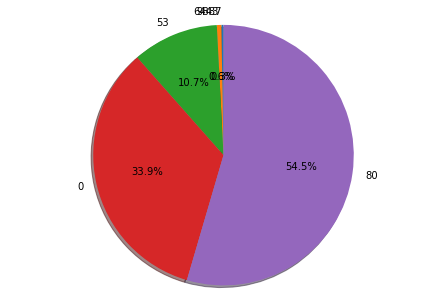

In [224]:
# Identify common src/dst pairs
df_drop = df[df['action'] == 'DROP']
plot_graph(df_drop, 'dport', title='Protocol', type='pie')

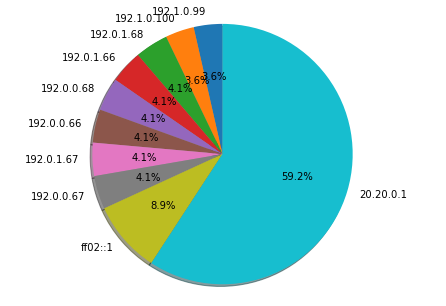

In [225]:
# Identify common src/dst pair cont.
plot_graph(df_drop, 'dip', title='Dest-ip', type='pie')

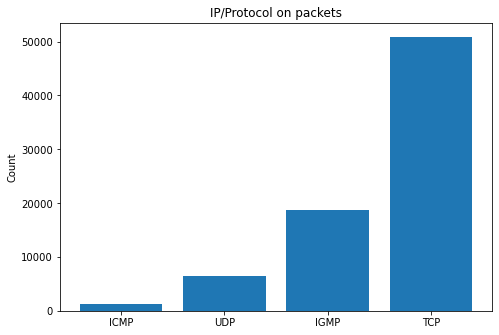

In [226]:
# Plot graph based on Protocols
plot_graph(df, 'proto', title='IP/Protocol on packets')


In [228]:
# Using Decision-Trees make predictions
# Since Information Gain(IG) methods have known to have some biases
# used the GINI method (which is also the default Attribute Selection Measure)

# Choose feature and target variables
feature_cols = ['proto', 'sip', 'dip', 'sport', 'dport']
x = df[feature_cols]
y = df['action']

# Data-preprocessing using scikitlearn packages:
#  - LabelEncoder - Encode target variables (here 'action')
#  - oneHotEncoder - Encode feature variables 

# Step-1:
# Using the LabelEncoder transform the predictor variable
le = preprocessing.LabelEncoder()

# Fit LabelEncoder
le.fit(y)

# Check/print the classes - expect to see TERM, PASS, DROP
print('LabelEncoder classes for Actions = {0}'.format(le.classes_))

# Transform/encode values based on LabelEncoder
y_transform = le.transform(y)

# Step-2: 
# Using the OneHotEncoder scheme to transform feature variables
enc = OneHotEncoder(handle_unknown='ignore')

# Fit OneHotEncoder
enc.fit(x)

# Transform/encode feature columns
x_transform = enc.transform(x)

LabelEncoder classes for Actions = ['DROP' 'PASS' 'TERM']


In [229]:
# The dataset is now fully encoded to be run through the 
# DecisionTree classifier and predictor model.

# Step-1: 
# Split data into (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x_transform, y_transform, 
                                                    test_size=0.2, random_state=1) 

# Step-2:
# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Step-3:
# Train the Decision Tree classifier
clf = clf.fit(x_train, y_train)

# Step-4:
# Predict the response for test dataset
y_pred = clf.predict(x_test)

In [230]:
# Step-5:
# Check the accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Conclusion:
# Using Decision-Trees (GINI method), given certain packet/flow attributes we 
# predict with upto 78% accuracy if Firewall action is DROP, PASS or TERM 

Accuracy: 0.7804326767839845
